<a href="https://colab.research.google.com/github/ethangoldbeck/grit-hub/blob/master/1FinalReport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Network Analysis

Companies: Coca-Cola, Pepsi, Dr.Pepper


## Searcher code


In [0]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
try:
    import birdy
except ModuleNotFoundError:
    !pip install birdy
try:
    import ratelimiter
except ModuleNotFoundError:
    !pip install ratelimiter

  Created wheel for birdy: filename=birdy-0.3.2-cp36-none-any.whl size=10853 sha256=03f038e8cd11b692571523e67a688f04df02dcefa0cc186dd98b3d8fb6e0a042
  Stored in directory: /root/.cache/pip/wheels/ad/f9/a7/928ef99a65cfa8182e42fb0a052b0a61faa69b7d085fae2723
Successfully built birdy


In [0]:
import json, os, sys, time
from zipfile import ZipFile
from birdy.twitter import AppClient, UserClient, TwitterRateLimitError
from ratelimiter import RateLimiter


"""
Credentials can be found by selecting the "Keys and tokens" tab for your
application selected from:

https://developer.twitter.com/en/apps/
"""
DEFAULT_MAX_TWEETS = 10_000

def limited(until):
    duration = int(round(until - time.time()))
    print('Rate limited, sleeping for {:d} seconds'.format(duration))


class TwitterSearcher():

    def __init__(self, consumer_key, consumer_secret,
                 output_dir, max_tweets=DEFAULT_MAX_TWEETS):
        self._consumer_key = consumer_key
        self._consumer_secret = consumer_secret
        self._output_dir = output_dir
        self._max_tweets = max_tweets
        self._client = None
        self._max_id = None

    def client(self):
        if self._client is None:
            _cl = AppClient(self._consumer_key, self._consumer_secret)
            access_token = _cl.get_access_token()
            self._client = AppClient(
                self._consumer_key, self._consumer_secret, access_token)
        return self._client

    @RateLimiter(max_calls=440, period=60*15, callback=limited)
    def fetch_tweets(self, query):
        print(f'Fetching: "{query}" TO MAX ID: {self._max_id}')
        client = self.client()
        try:
            tweets = client.api.search.tweets.get(
                q=query,
                count=100,
                max_id=self._max_id).data['statuses']
        except TwitterRateLimitError:
            print("You've reached your Twitter API rate limit. "\
                "Wait 15 minutes before trying again")
            sys.exit()
        try:
            id_ = min([tweet['id'] for tweet in tweets])
        except ValueError:
            return None
        if self._max_id is None or id_ <= self._max_id:
            self._max_id = id_ - 1
        return tweets

    def initialize_max_id(self, file_list):
        for fn in file_list:
            n = int(fn.split('.')[0])
            if self._max_id is None or n < self._max_id:
                self._max_id = n - 1
        if self._max_id is not None:
            print('Found previously fetched tweets. '\
                  'Setting max_id to %d' % self._max_id)

    def halt(self, _id):
        print('Reached historically fetched ID: %d' % _id)
        print('In order to re-fetch older tweets, ' \
            'remove tweets from the output directory or output zip file.')
        print('\n!!IMPORTANT: Tweets older than 7 days will not be re-fetched')
        return

    def search(self, query, dozip=True, verbose=False):
        output_dir = os.path.join(self._output_dir, '_'.join(query.split()))
        outzip = None
        self._max_id = None
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        if dozip:
            fn = os.path.join(output_dir, '%s.zip' % '_'.join(query.split()))
            outzip = ZipFile(fn, 'a')
        if dozip:
            file_list = [f for f in outzip.namelist() if f.endswith('.json')]
        else:
            file_list = [f for f in os.listdir(output_dir) if f.endswith('.json')]
        self.initialize_max_id(file_list)
        try:
            while True:
                tweets = self.fetch_tweets(query)
                if tweets is None:
                    print('Search Completed')
                    return
                for tweet in tweets:
                    if verbose:
                        print(tweet['id'])
                    fn = '%d.json' % tweet['id']
                    if dozip:
                        if fn in (file_list):
                            self.halt(tweet['id'])
                        else:
                            outzip.writestr(fn, json.dumps(tweet, indent=4))
                            file_list.append(fn)
                    else:
                        path = os.path.join(output_dir, fn)
                        if fn in (file_list):
                            self.halt(tweet['id'])
                        else:
                            with open(path, 'w') as outfile:
                                json.dump(tweet, outfile, indent=4)
                            file_list.append(fn)
                    if len(file_list) >= self._max_tweets:
                        print('Reached maximum tweet limit of: %d' % self._max_tweets)
                        return
        except KeyboardInterrupt:
            print('Search interrupted. Re-run to continue.')
            sys.exit()
        except:
            raise
        finally:
            if outzip is not None:
                outzip.close()

## Extract Tweets for Chosen Companies:
##Coca-Cola, Pepsi, Dr. Pepper


`

In [0]:
CONSUMER_KEY='bAD0e32cKtuhynw1wPHdFGoR3'
CONSUMER_SECRET='nFLQvd70CiSlJEQwNTPr3Hf9GddHnBUMCp3xixlbTgfFUDxbEX'
OUTPUT_DIR = '/content/drive/My Drive/Network Analysis/soda'

searcher = TwitterSearcher(CONSUMER_KEY, CONSUMER_SECRET, OUTPUT_DIR, max_tweets = 10000)
searcher.search('@CocaCola', dozip=True)
searcher.search('@pepsi', dozip=True)
searcher.search('@drpepper', dozip=True)

Fetching: "@CocaCola" TO MAX ID: None
Fetching: "@CocaCola" TO MAX ID: 1229821933103075328
Fetching: "@CocaCola" TO MAX ID: 1229798840561229825
Fetching: "@CocaCola" TO MAX ID: 1229767860047818751
Fetching: "@CocaCola" TO MAX ID: 1229743637677740032
Fetching: "@CocaCola" TO MAX ID: 1229713082097729535
Fetching: "@CocaCola" TO MAX ID: 1229686959527858175
Fetching: "@CocaCola" TO MAX ID: 1229654876814221311
Fetching: "@CocaCola" TO MAX ID: 1229623583242117119
Fetching: "@CocaCola" TO MAX ID: 1229610977932394495
Fetching: "@CocaCola" TO MAX ID: 1229607384311619584
Fetching: "@CocaCola" TO MAX ID: 1229598977147969535
Fetching: "@CocaCola" TO MAX ID: 1229592248540680191
Fetching: "@CocaCola" TO MAX ID: 1229586415312424961
Fetching: "@CocaCola" TO MAX ID: 1229581105554173951
Fetching: "@CocaCola" TO MAX ID: 1229576203385831423
Fetching: "@CocaCola" TO MAX ID: 1229570269217464325
Fetching: "@CocaCola" TO MAX ID: 1229550547562385408
Fetching: "@CocaCola" TO MAX ID: 1229531746619871232
Fetching

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# Prepare Data

In [0]:
import glob
import os
import shutil
import json
import csv
import zipfile

In [0]:
import botometer

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
tweetzipfiles = glob.glob('/content/drive/My Drive/Network Analysis/soda/*.zip')

In [0]:
tweetzipfiles

['/content/drive/My Drive/Colab Notebooks/soda/@CocaCola.zip',
 '/content/drive/My Drive/Colab Notebooks/soda/@pepsi.zip',
 '/content/drive/My Drive/Colab Notebooks/soda/@drpepper.zip']

In [0]:
uniqueusers = {}

for tweetzipfile in tweetzipfiles:
  zf = zipfile.ZipFile(tweetzipfile)
  for i, obj in enumerate(zf.infolist()):
    tweetjson = json.load(zf.open(obj))
    userwhotweeted = tweetjson['user']['screen_name'] 
    if userwhotweeted in uniqueusers:
       uniqueusers[userwhotweeted] += 1
    if userwhotweeted not in uniqueusers:
       uniqueusers[userwhotweeted] = 1

In [0]:
userstoinclude =  set()

usercount = 0
for auser in uniqueusers:
  if uniqueusers[auser] > 3:
    usercount += 1
    userstoinclude.add(auser)

print(len(userstoinclude))

603


#Removing Likely Bots



In [0]:
rapidapi_key = "541b85acd4mshaba2a5b7282bfacp11bc35jsnd0e5693346da" # now it's called rapidapi key
twitter_app_auth = {
    'consumer_key': 'bAD0e32cKtuhynw1wPHdFGoR3',
    'consumer_secret': 'nFLQvd70CiSlJEQwNTPr3Hf9GddHnBUMCp3xixlbTgfFUDxbEX',
    'access_token': '1227324069130817538-o8bByZ3nlvC1hhmVEtkc8ak75LMZss',
    'access_token_secret': 'xfl5FaRzlQop5M57ZwYRWuu0H0tZzvTK7rreERcVYGNkr',
  }
bom = botometer.Botometer(wait_on_ratelimit=True,
                          rapidapi_key=rapidapi_key,
                          **twitter_app_auth)


In [0]:
accounts = [userstoinclude]


In [0]:
ataccounts = ['@' + user for user in userstoinclude]


In [0]:
botdict = {}
for screen_name, result in bom.check_accounts_in(ataccounts):
    botdict[screen_name] = result

In [0]:
botdict['@lluviapay'].keys()

dict_keys(['cap', 'categories', 'display_scores', 'scores', 'user'])

In [0]:
goodbotdict = {}
for user in botdict:
  if botdict[user].keys() == botdict['@lluviapay'].keys():
    goodbotdict[user] = botdict[user]

# a few users in first dictionary an errors as there keys because the page did not exist - this code eliminates the errored users


In [0]:
botornotdict = {}

for user in goodbotdict:
  if goodbotdict[user]['scores']['english'] > .43:
    botornotdict[user] = 1
  else:
    botornotdict[user] = 0 

Used .43 based on threshold in pew research article.  .43 is the threshold they used

In [0]:
botusers = []
for user in botornotdict:
  if botornotdict[user] == 1:
    botusers.append(user)

In [0]:
noatbotusers = []
for user in botusers:
  noatbotusers.append(user[1:])

In [0]:
nobotusers = []
for user in userstoinclude:
  if user not in noatbotusers:
    nobotusers.append(user)

# Segment Users by Follower Count

In [0]:
followercount = {}

for tweetzipfile in tweetzipfiles:
  zf = zipfile.ZipFile(tweetzipfile)
  for i, obj in enumerate(zf.infolist()):
    tweetjson = json.load(zf.open(obj))
    followcount = tweetjson['user']['followers_count']
    userwhotweeted = tweetjson['user']['screen_name'] 
    if userwhotweeted in nobotusers:
      followercount[userwhotweeted] = followcount

Only users with over 1000 followers will be kept - this means we will have a list of only fairly influential to very influential users.  

In [0]:
highfollowerusers = []
for user in followercount:
  if followercount[user] > 1000:
    highfollowerusers.append(user)

In [0]:
len(highfollowerusers)

186

#Write User Edgelist

In [0]:
edgelist = open('/content/drive/My Drive/Network Analysis/highfolloweruser_edgelist_for_gephi.csv', 'w')
csvwriter = csv.writer(edgelist)
header = ['Source', 'Target']
csvwriter.writerow(header)


15

In [0]:
print('Writing edge list')

for tweetzipfile in tweetzipfiles:
  zf = zipfile.ZipFile(tweetzipfile)
  for i, obj in enumerate(zf.infolist()):
    tweetjson = json.load(zf.open(obj))
    userwhotweeted = tweetjson['user']['screen_name']
    if userwhotweeted in highfollowerusers:

      users = tweetjson['entities']['user_mentions']
      if len(users) > 0:
        for auser in users:
          screenname = auser['screen_name']
          row = [userwhotweeted, screenname]
          csvwriter.writerow(row)
edgelist.close()

Writing edge list


# Gephi User Graph


In [0]:
from google.colab import files
from IPython.display import Image

In [0]:
uploaded = files.upload()

Saving users.png to users.png


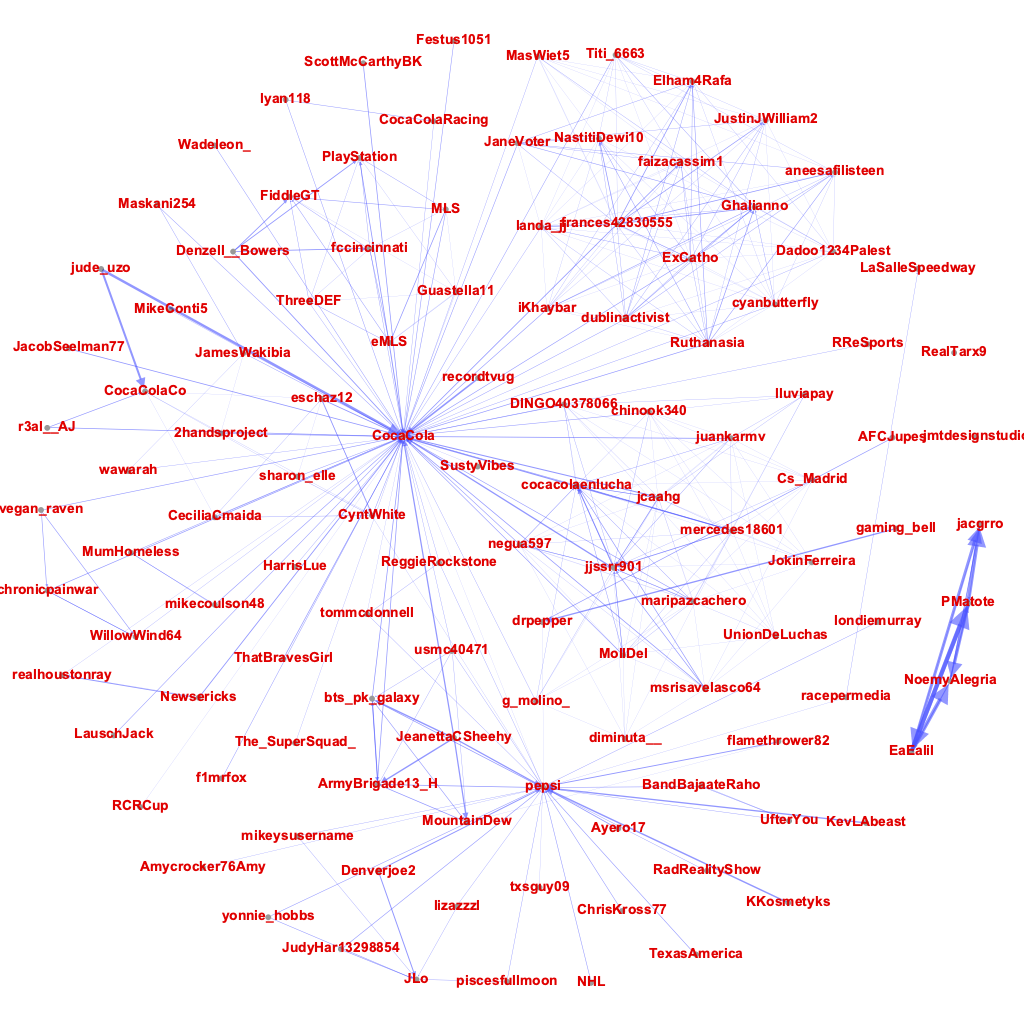

In [0]:
Image('users.png', width=800)

# Most Central Users
(1000 followers or more)

#Coca-Cola:


Jude Uze, eMLS/MLS, recordtvug, ReggieRockstone, JacobSeelman77, MikeConti5, SustyVibes, ScottMcCarthyBK, Denzell_Bowers, mercedes18601

Jude Uze, JacobSeelman77, MikeConti5, ScottMcCarthyBK, Denzell_Bowers, and mercedes18601 seem somewhat regular people that are big fans of coca-cola.  Send them swag and coupons for coca-cola products.  They would most likely promote our brand further/post pictures with our swag

ReggieRockstone, recordtvug, and SustyVibes are all people or entities in Africa. We can use these users to further promote our profucts in Africa

eMLS/MLS represents the national soccer league and there esports devision.  We should partner with them to offer participents/winners coca-cola related prizes

#Pepsi:


KevLAbeast, BandBajeateRaho, ArmyBrigade13_H, Denverjoe2, JeanettaCSheely, txsguy09, TexasAmerica, RadRealityShow, Ayero17, UfterYou

BandBajeateRaho, ArmyBrigade13_H, Denverjoe2, JeanettaCSheely, and Ayero17 are noraml users who like pepsi. Send them swag and coupons for coca-cola products. They would most likely promote our brand further/post pictures with our swag

txsguy09, TexasAmerica are users from Texas.  Along with sending them swag, we should increase our advertising in Texas as it seems we have a following there

KevLABeast is a professional competative eater.  Let's get him as a sponsor for pepsi so he can promote our products at events he competes in/wins as well as with his tweets.

UfterYou is a popular brand awareness twitter user that tweets about product problems (not sealed/mold/broken product).  Let's look into these tweets further to see what is going wrong with our products

#Dr. Pepper


gaming_bell, g_molino_, Cs_Madrid, MoliDel, AFCjupes

g_molino_, MoliDel, and AFCjupes seem noraml users who like Dr. Pepper. Send them swag and coupons for coca-cola products. They would most likely promote our brand further/post pictures with our swag

gaming_bell is a Dr. Pepper lover.  It look like she is already an official ambassador for Dr. Pepper, but it she is not, we need to make that happen immediately.  All her posts are about Dr. Pepper

Cs_Madrid is an entity in Madrid, Spain.  We should increase our marketing in Madrid as it seems we have a following there

There are only 5 users with more than 1000 followers that tweeted @ Dr.pepper.  We had more with less than 1000.  We need to increase our popularity with bigger influencers.  We could try to steal some users from Coca-Cola or Pepsi.

#Most Important Bridgers

CyntWhite, tommcdonnell, bts_pk_galexty, eschaz12, MountainDew, usmc40471 seem to be the biggest bridgers in our user network.

CyntWhite is a popular conservative tweeter.  She seems to like both coca-cola and pepsi.  Either company could win her over with a gesture and possibly capture some of her 10,000 followers as well.

tommcdonnell, eschaz12, and usmc40471 seem to be standard twitter users.  Either coca-cola or pepsi could win these users and a share of their 1000+ users.

bts_pk_gateway is an entity in Pakistan.  Either coca-cola or pepsi could win this user and further their awareness in the market in Pakistan.

MountainDew is a competitor or both Coca-Cola and Pepsi.  Engaging with Mountain Dew would probably be beneficial for either company for some mutual marketing.

Dr. Pepper has too few users tweeting with over 1000 followers to have bridgers.

# Semantic Network Analysis

#Prepare Data

In [0]:
import nltk
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
import glob
import os
import re
import shutil
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import csv
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
import string
import itertools
import zipfile
import json
punctuation = string.punctuation
stopwordsset = set(stopwords.words("english"))
stopwordsset.add("'s")
stopwordsset.add("rt")
stopwordsset.add("'")
stopwordsset.add("...")
stopwordsset.add("m")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
from textblob import TextBlob

In [0]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [0]:
#Removing urls
def removeURL(text):
  result = re.sub(r"http\S+", "", text)
  return result
#Extracting contextual words from a sentence
# tokenizing is taking out all the words in a sentence and turning it into tokens/words
def tokenize(text):
  #lower case
  text = text.lower()
  #split into individual words
  words = word_tokenize(text)
  return words
#stem - peaches : peach : reduce the number of repeated words
def stem(tokenizedtext):
  rootwords = []
  for aword in tokenizedtext:
    aword = ps.stem(aword)
    rootwords.append(aword)
  return rootwords
#removes useless words such as a, an, the
def stopWords(tokenizedtext):
  goodwords = []
  for aword in tokenizedtext:
    if aword not in stopwordsset:
      goodwords.append(aword)
  return goodwords
# feature reduction. taking words and getting their roots and graphing only the root words
def lemmatizer(tokenizedtext):
  lemmawords = []
  for aword in tokenizedtext:
    aword = wn.lemmatize(aword)
    lemmawords.append(aword)
  return lemmawords
#inputs a list of tokens and returns a list of unpunctuated tokens/words
def removePunctuation(tokenizedtext):
  nopunctwords = []
  for aword in tokenizedtext:
    if aword not in punctuation:
      nopunctwords.append(aword)
  cleanedwords = []
  for aword in nopunctwords:
    aword = aword.translate(str.maketrans('', '', string.punctuation))
    cleanedwords.append(aword)
  return cleanedwords

In [0]:
tweetzipfiles = glob.glob('/content/drive/My Drive/1Final Report/soda/*.zip')

In [0]:
tweetzipfiles

['/content/drive/My Drive/Colab Notebooks/soda/@CocaCola.zip',
 '/content/drive/My Drive/Colab Notebooks/soda/@pepsi.zip',
 '/content/drive/My Drive/Colab Notebooks/soda/@drpepper.zip']

# Segment Words by Sentiment (TextBlob)

#Extract Nouns (Spacy)



In [0]:
baduniquenouns = {}
count = 0
for tweetzipfile in tweetzipfiles:
  zf = zipfile.ZipFile(tweetzipfile)
  for i, obj in enumerate(zf.infolist()):
    tweetjson = json.load(zf.open(obj))
    count += 1
    if count % 1000 == 0:
      print(count)

    text = tweetjson['text']
    blobbedtext = TextBlob(text)
    if blobbedtext.sentiment.polarity < 0:
      nourlstext = removeURL(text)
      tokenizedtext = tokenize(nourlstext)
      nostopwordstext = stopWords(tokenizedtext)
      lemmatizedtext = lemmatizer(nostopwordstext)
      nopuncttext = removePunctuation(lemmatizedtext)
      fulltext = ' '
      fulltext = fulltext.join(nopuncttext)
      doc = nlp(fulltext)
      nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN"]
      # Tried nouns verbs and adjectives but just nouns better 
      #nounverbadj = [token.lemma_ for token in doc if token.pos_ == "NOUN" or token.pos_ == "VERB" or token.pos_ == 'ADJ']
      #print(tokenizedtext)
      #print(nostopwordstext)
      #print(lemmatizedtext)
      #print(nopuncttext)
      for aword in nouns:
        if aword in baduniquenouns:
          baduniquenouns[aword] += 1
        if aword not in baduniquenouns:
          baduniquenouns[aword] = 1

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000


In [0]:
gooduniquenouns = {}
count = 0
for tweetzipfile in tweetzipfiles:
  zf = zipfile.ZipFile(tweetzipfile)
  for i, obj in enumerate(zf.infolist()):
    tweetjson = json.load(zf.open(obj))
    count += 1
    if count % 1000 == 0:
      print(count)

    text = tweetjson['text']
    blobbedtext = TextBlob(text)

    if blobbedtext.sentiment.polarity > 0:
      nourlstext = removeURL(text)
      tokenizedtext = tokenize(nourlstext)
      nostopwordstext = stopWords(tokenizedtext)
      lemmatizedtext = lemmatizer(nostopwordstext)
      nopuncttext = removePunctuation(lemmatizedtext)
      fulltext = ' '
      fulltext = fulltext.join(nopuncttext)
      doc = nlp(fulltext)
      nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN"]
      #print(tokenizedtext)
      #print(nostopwordstext)
      #print(lemmatizedtext)
      #print(nopuncttext)
      for aword in nouns:
        if aword in gooduniquenouns:
          gooduniquenouns[aword] += 1
        if aword not in gooduniquenouns:
          gooduniquenouns[aword] = 1

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000


#Only Popular Words

In [0]:
badnounstoinclude = set()
badwordcount = 0
for aword in baduniquenouns:
  if baduniquenouns[aword] > 10:
    badwordcount += 1
    badnounstoinclude.add(aword)

In [0]:
len(badnounstoinclude)

249

In [0]:
goodnounstoinclude = set()
goodwordcount = 0
for aword in gooduniquenouns:
  if gooduniquenouns[aword] > 20:
    goodwordcount += 1
    goodnounstoinclude.add(aword)

In [0]:
len(goodnounstoinclude)

367

#Write Word Edgelist

In [0]:
edgelist = open('/content/drive/My Drive/Network Analysis/goodword_edgelist_for_gephi.csv','w')
csvwriter = csv.writer(edgelist)

header = ['Source', 'Target', 'Type']
csvwriter.writerow(header)
uniquewords = {}
count = 0

for tweetzipfile in tweetzipfiles:
  zf = zipfile.ZipFile(tweetzipfile)
  for i, obj in enumerate(zf.infolist()):
    tweetjson = json.load(zf.open(obj))
    count += 1
    if count % 1000 == 0:
      print(count)

    text = tweetjson['text']
    blobbedtext = TextBlob(text)

    if blobbedtext.sentiment.polarity > 0:
      nourlstext = removeURL(text)
      tokenizedtext = tokenize(nourlstext)
      nostopwordstext = stopWords(tokenizedtext)
      lemmatizedtext = lemmatizer(nostopwordstext)
      nopuncttext = removePunctuation(lemmatizedtext)
      fulltext = ' '
      fulltext = fulltext.join(nopuncttext)
      doc = nlp(fulltext)
      nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN"]
      #print(tokenizedtext)
      #print(nostopwordstext)
      #print(lemmatizedtext)
      #print(nopuncttext)
    
    goodwords = []
    for aword in nouns:
      if aword in goodnounstoinclude:
        goodwords.append(aword.replace(',',''))
    
    allcombos = itertools.combinations(goodwords, 2)#set to number of words
    for acombo in allcombos:
      row = []
      for anode in acombo:
        row.append(anode)
      row.append('Undirected')
      csvwriter.writerow(row)

edgelist.close()
      


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000


In [0]:
edgelist = open('/content/drive/My Drive/Network Analysis/badword_edgelist_for_gephi.csv','w')
csvwriter = csv.writer(edgelist)

header = ['Source', 'Target', 'Type']
csvwriter.writerow(header)
uniquewords = {}
count = 0

for tweetzipfile in tweetzipfiles:
  zf = zipfile.ZipFile(tweetzipfile)
  for i, obj in enumerate(zf.infolist()):
    tweetjson = json.load(zf.open(obj))
    count += 1
    if count % 1000 == 0:
      print(count)

    text = tweetjson['text']
    blobbedtext = TextBlob(text)

    if blobbedtext.sentiment.polarity > 0:
      nourlstext = removeURL(text)
      tokenizedtext = tokenize(nourlstext)
      nostopwordstext = stopWords(tokenizedtext)
      lemmatizedtext = lemmatizer(nostopwordstext)
      nopuncttext = removePunctuation(lemmatizedtext)
      fulltext = ' '
      fulltext = fulltext.join(nopuncttext)
      doc = nlp(fulltext)
      nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN"]
      #print(tokenizedtext)
      #print(nostopwordstext)
      #print(lemmatizedtext)
      #print(nopuncttext)

    badwords = []
    for aword in nouns:
      if aword in badnounstoinclude:
        badwords.append(aword.replace(',',''))
    
    allcombos = itertools.combinations(badwords, 2)#set to number of words
    for acombo in allcombos:
      row = []
      for anode in acombo:
        row.append(anode)
      row.append('Undirected')
      csvwriter.writerow(row)

edgelist.close()
      

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000


# Gephi Word Graphs


In [0]:
uploaded2 = files.upload()

Saving goodwords.png to goodwords.png


In [0]:
uploaded3 = files.upload()

Saving badwords.png to badwords.png


#Positive Sentiment Word Network

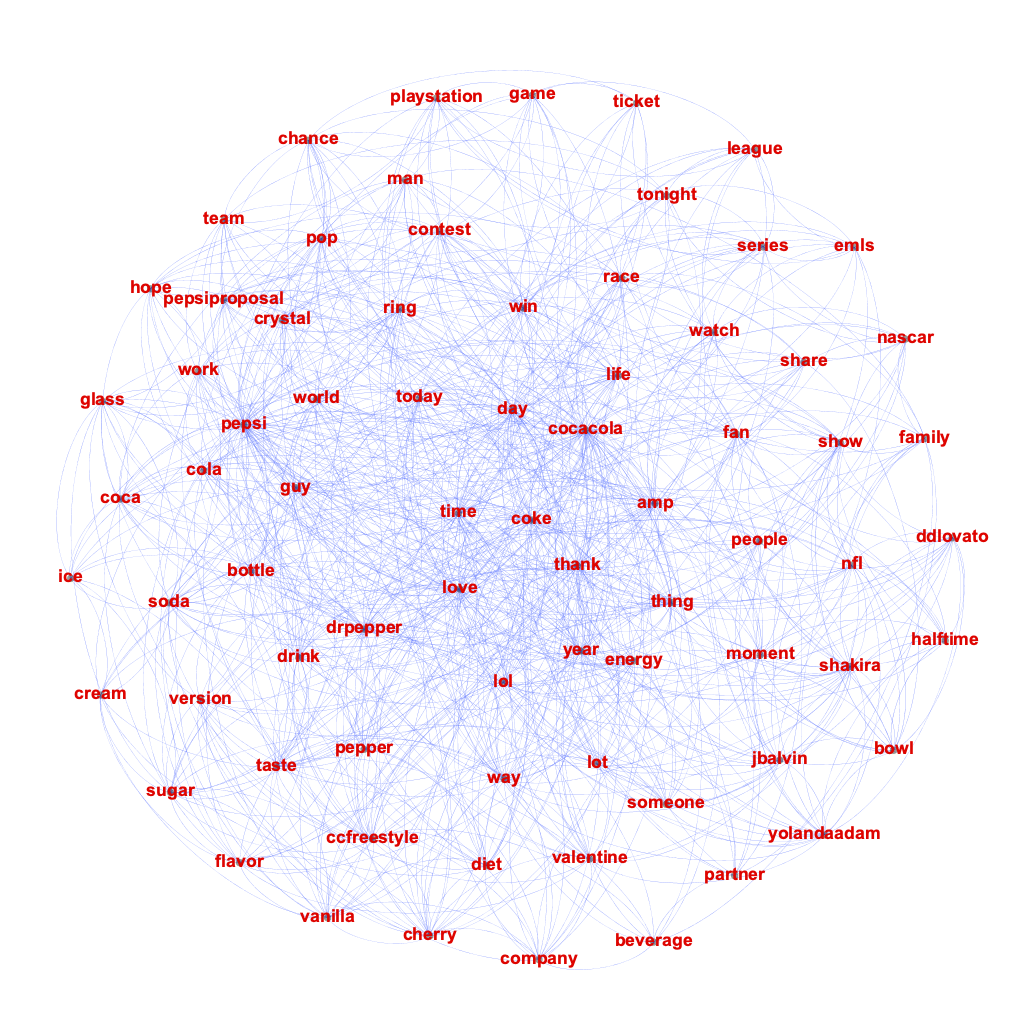

In [0]:
Image('goodwords.png', width=800)

#Negative Sentiment Word Network

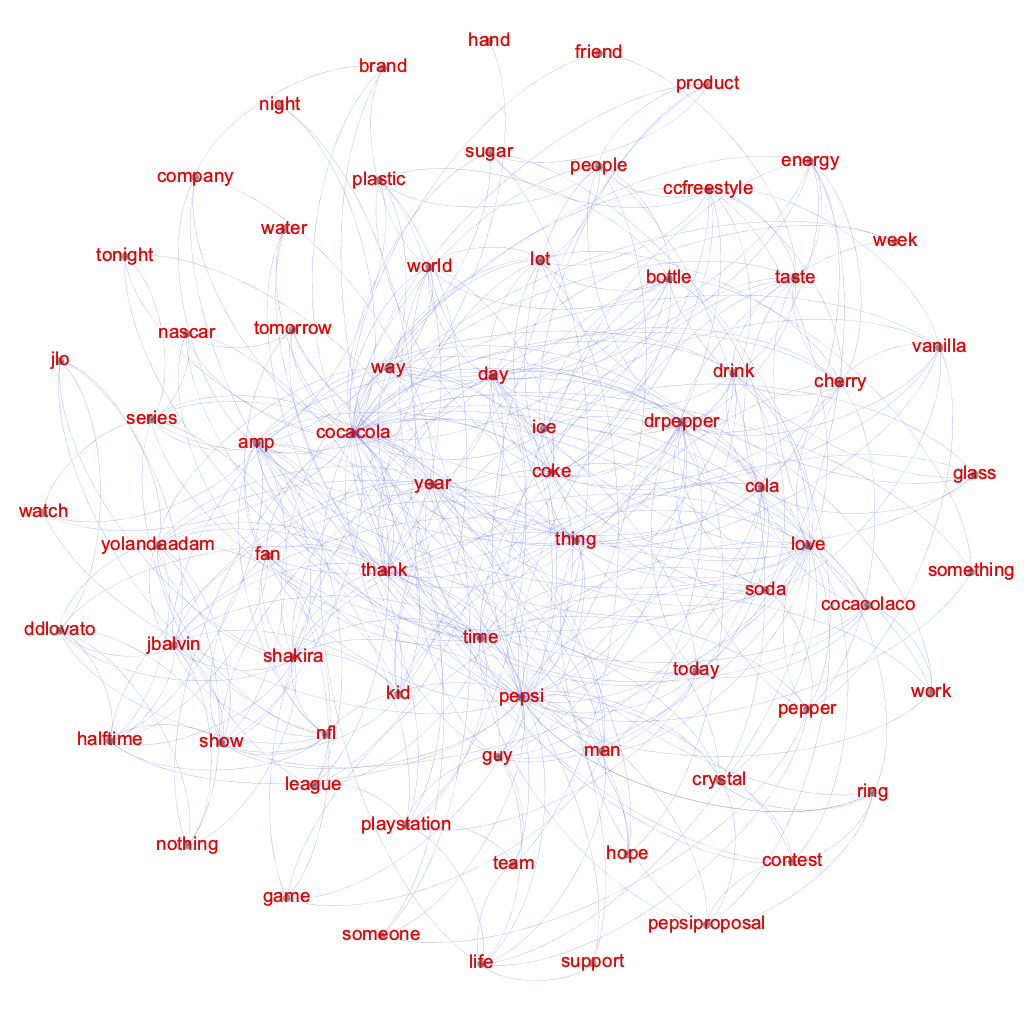

In [0]:
Image('badwords.png', width=800)

#Word Clusters Owned

##Only Nouns

#####Words were separated into positive and negative sentiment, however, it doesn't seem to reflect the setiment in our networks.  Since setiment analysis is an imperfect science and had minimal effect on segmenting our data, I won't word cluster by positive or negative sentiment. I also recommend not performing this separation on future analyses

#Coca-Cola


Nascar, Series, Amp, Thank, Tonight

Nascar and Series are part of the Coca-Cola network because of a partnership between Coke and Nascar.  Continue to build this relationship as it has people talking about Coca-Cola.

Amp is an energy drink produced by pepsi.  Perhaps people are looking for a coca-cola alterative to this product.

Thank is here because of the coca-cola thank you fund. Let's continue to promote this fund as it has people talking about our products.

Tonight could be here because people drink our product the most at night.  Perhaps out drink is the perferred mixer (for an alcohlic drink) and we should partner with popular liquor brands.

#Pepsi




Crystal, Pepsiproposal, Ring, NFL, Halftime, League  

These words represent two clusters

Crystal, Pepsiproposal, and Ring are all cluster about our crystal pepsi proposal promotion.  We should run this promotion again and other promotions similar because it is causing people to talk about our products

NFL, Halftime, and League are all a cluster about pepsi's parntership with the NFL, especially during the superbowl halftime show (sponsored by pepsi).  We should continue our partnership with the NFL.

#Dr.Pepper


Vanilla, Cherry, Taste, Flavor, Cream

This cluster shows us that when people discuss Dr. Pepper, they are mostly concerned with it's taste/flavor.

People are talking about Dr. Pepper cherry vanilla, we should keep producing this product and also raise our advertising efforts about this product.

People are also talking about Dr. Pepper cream soda, we should keep producing this product and also raise our advertising efforts about this product.

#Bridging Words



Glass, Energy, Sugar, Ice, Valentine, Drink, Love, Contest, CCfreestyle, Playstation, Soda

Words like glass, energy, sugar, ice (cold), drink don't separarate our sodas from competitor sodas.

It also seems like all soda brands hold some kind of contest.  I recommend we keep contests to compete with other brands with contests as well and people seem to really like contests.

Coca-cola has the I love Coke campiagn. Although it has gained some traction - it seems to also cause people to express love for our competitors soda as well.  I recommend Coke stop this campaign and try a new advertising scheme that doesn't improve our competitors social media presence.

Valentines day seems to be a big day for soda.  I think with the right push, any of these soda companies could gain the valentines day soda market - which could lead to better Spring sales overall.

CCfreestyle is a Coca-Cola brand drink machine. It seems to be very popular but since the machine also offers Dr. Pepper varieties it has people talking about both Coke and Dr. Pepper.  I would recommend keeping these machines as they are very popular and could increase the strength of a beneficial relationship between Coke and Dr. Pepper.

Dr. Pepper currently has a deal with playstation - if you buy a certain amount of Dr. Pepper you get a Playstation store credit.  I recommend Dr. Pepper end this relationship as people are talkng about Coke or Pepsi in conjunction with Playstation more than people are talking about Dr. Pepper.